### Simple neural network developed using pytorch, for binary classification.

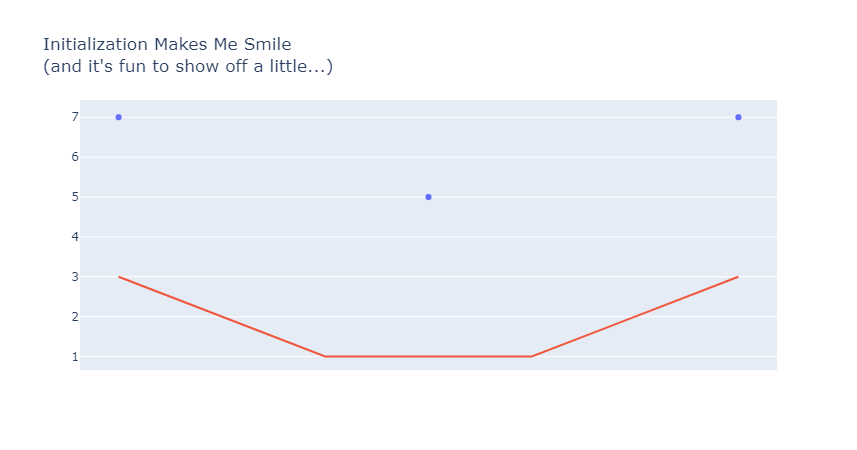

In [1]:
import numpy as np
import pandas as pd
import ipdb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import ShuffleSplit

import chart_studio.plotly as ply
import chart_studio.tools as plytool
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as plyoff

#plytool.set_credentials_file(username='ahowe42', api_key='')
plyoff.init_notebook_mode(connected=True)
x1 = [1,4,7]; y1 = [7,5,7]
x2 = [1,2,3,4,5,6,7]; y2 = [3,2,1,1,1,2,3]
plyoff.iplot(go.Figure(data=[go.Scatter({'x':x1, 'y':y1, 'mode':'markers'}), go.Scatter({'x':x2, 'y':y2, 'mode':'lines'})],
                       layout=go.Layout(autosize=False, width=400, showlegend=False,
                                        xaxis={'showgrid':False, 'showticklabels':False},
                                        title="Initialization Makes Me Smile<br>(and it's fun to show off a little...)")))


In [2]:
''' define the model class for a neural net with variable hidden layers & dropout;
this NN will be used for binary classification '''
class myNN(nn.Module):
    def __init__(self, layerNodes, wInit, pDropout, activations):
        super(myNN, self).__init__()
        self.activations = activations[1:]
        self.len = len(layerNodes)-1
        self.drop = nn.Dropout(pDropout)
        self.linears = nn.ModuleList() # could also use nn.Sequential
        for I, O in zip(layerNodes, layerNodes[1:]):
            # create the layer
            lin = nn.Linear(I, O)
            # initialize it
            nn.init.zeros_(lin.bias)
            if wInit == 'uni':
                nn.init.uniform_(lin.weight)
            elif wInit == 'xav':
                nn.init.xavier_uniform_(lin.weight)
            elif wInit == 'kai':
                nn.init.kaiming_uniform_(lin.weight, nonlinearity='relu')
            # and now add it
            self.linears.append(lin)

    def forward(self,x):
        for i, (L, A) in enumerate(zip(self.linears, self.activations)):
            # dropout if not the output layer
            if i < self.len - 1:
                x = self.drop(L(x))
            else:
                x = L(x)
                
            # compute the activation
            if A == 'relu':
                x = nn.functional.relu(x)
            elif A == 'sigmoid':
                x = torch.sigmoid(x)
            elif A == 'leakyrelu':
                x = nn.functional.leaky_relu(x)
            elif A == 'tanh':
                x = nn.functional.tanh(x)

        return x
    
    def __str__(self):
        mn = super(myNN, self).__str__()
        return '%s\nActivations: %s'%(mn, self.activations)

(100, 2)
(100, 1)


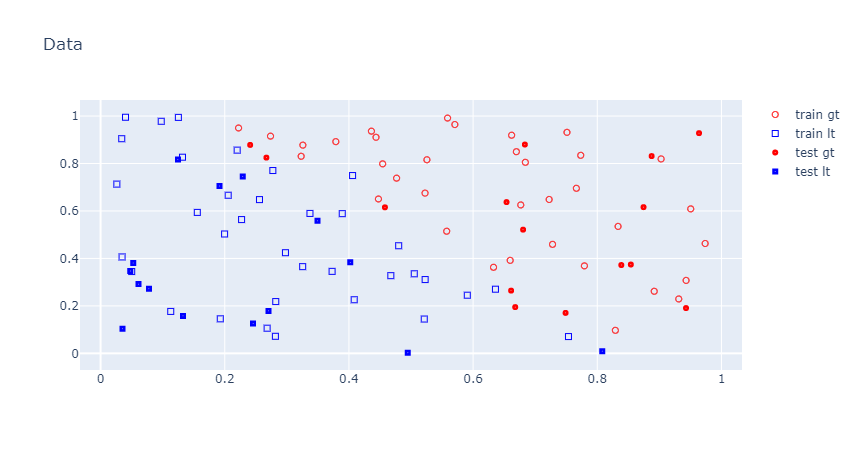

In [3]:
# create simulated data
np.random.seed = 42
n = 100
p = 2
trainPerc = 0.7

x = np.random.rand(n, p)
print(x.shape)
y = x[:,0]*5 + x[:,1]*3 + np.random.rand(n)
y = np.atleast_2d(y > np.median(y)).T
print(y.shape)

# partition randomly into the training & testing sets
ss = ShuffleSplit(n_splits=1, train_size=trainPerc)
(trn, tst) = next(ss.split(x))
trnX = x[trn,:]; trnY = y[trn,:]
tstX = x[tst,:]; tstY = y[tst,:]

# plot the data - training
trnYFlat = np.squeeze(trnY); tstYFlat = np.squeeze(tstY); # squeee y for indexing into x
trc = [go.Scatter({'x':trnX[trnYFlat,0], 'y':trnX[trnYFlat,1], 'name':'train gt', 'mode':'markers',
                   'marker':{'color':'red', 'symbol':'circle-open'}}), 
        go.Scatter({'x':trnX[~trnYFlat,0], 'y':trnX[~trnYFlat,1], 'name':'train lt', 'mode':'markers',
                   'marker':{'color':'blue', 'symbol':'square-open'}}),
        go.Scatter({'x':tstX[tstYFlat,0], 'y':tstX[tstYFlat,1], 'name':'test gt', 'mode':'markers',
                   'marker':{'color':'red', 'symbol':'circle-dot'}}), 
        go.Scatter({'x':tstX[~tstYFlat,0], 'y':tstX[~tstYFlat,1], 'name':'test lt', 'mode':'markers',
                   'marker':{'color':'blue', 'symbol':'square-dot'}})]
plyoff.iplot(go.Figure(data=trc, layout=go.Layout(title = 'Data')))

In [4]:
# now make the datasets & dataloaders
batchSize = 5

# Create the data class
class Data(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.Tensor(y.astype(int))
        self.len, self.p = self.x.shape
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

trainData = Data(trnX, trnY)
trainLoad = DataLoader(dataset=trainData, batch_size=batchSize)
testData = Data(tstX, tstY)
testLoad = DataLoader(dataset=testData, batch_size=len(testData))

In [5]:
# define the modeling objects
layers = (p, 10, 20, 10, 1) # input layer size, hidden layer sizes, output layer size
activations = (None, 'relu', 'relu', 'relu', 'sigmoid')
learningRate = 0.1
pDropout = 0.2
weightInit = 'kai'


model = myNN(layers, weightInit, pDropout, activations)
print(model)
optimizer = torch.optim.SGD(model.parameters(), lr = learningRate)
loss = nn.BCELoss()

myNN(
  (drop): Dropout(p=0.2)
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)
Activations: ('relu', 'relu', 'relu', 'sigmoid')


In [6]:
# train!
epochs = 500
talkFreq = 0.2

trnLoss = [np.inf]*epochs
trnAcc = [0]*epochs
tstLoss = [np.inf]*epochs
tstAcc = [0]*epochs
for i in range(epochs):
    # train with minibatch gradient descent
    model.train(True)
    for x, y in trainLoad:
        # forward step
        yhat = model(x)
        # compute loss (not storing for now, will do after minibatching)
        l = loss(yhat, y)
        # backward step
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    with torch.no_grad():
        model.train(False) # model.eval()
        # evaluate loss & accuracy on training set
        yhat = model(trainData.x)
        trnLoss[i] = loss(yhat, trainData.y)
        trnAcc[i] = np.sum((yhat.detach().numpy()>0.5) == trainData.y.numpy())/len(trainData)
        # evaluate loss & accuracy on testing set
        yhat = model(testData.x)
        tstLoss[i] = loss(yhat, testData.y)
        tstAcc[i] = np.sum((yhat.detach().numpy()>0.5) == testData.y.numpy())/len(testData)
        # maybe talk
        if i % (epochs*talkFreq) == 0:
            print('Epoch %d Training (Testing) Loss = %0.2f (%0.2f), & Accuracy = %0.2f (%0.2f)'%
                  (i, trnLoss[i], tstLoss[i], trnAcc[i], tstAcc[i]))
    
print('==========\nTraining Initial Loss (Accuracy) = %0.2f (%0.2f), Final Loss (Accuracy) = %0.2f (%0.2f)'%\
      (trnLoss[0], trnAcc[0], trnLoss[-1], trnAcc[-1]))
print('Testing Initial Loss (Accuracy) = %0.2f (%0.2f), Final Loss (Accuracy) = %0.2f (%0.2f)'%\
      (tstLoss[0], tstAcc[0], tstLoss[-1], tstAcc[-1]))

Epoch 0 Training (Testing) Loss = 0.61 (0.59), & Accuracy = 0.54 (0.70)
Epoch 100 Training (Testing) Loss = 0.11 (0.16), & Accuracy = 0.96 (0.90)
Epoch 200 Training (Testing) Loss = 0.13 (0.11), & Accuracy = 0.94 (0.93)
Epoch 300 Training (Testing) Loss = 0.09 (0.16), & Accuracy = 0.96 (0.90)
Epoch 400 Training (Testing) Loss = 0.06 (0.37), & Accuracy = 0.99 (0.90)
Training Initial Loss (Accuracy) = 0.61 (0.54), Final Loss (Accuracy) = 0.06 (0.99)
Testing Initial Loss (Accuracy) = 0.59 (0.70), Final Loss (Accuracy) = 0.30 (0.93)


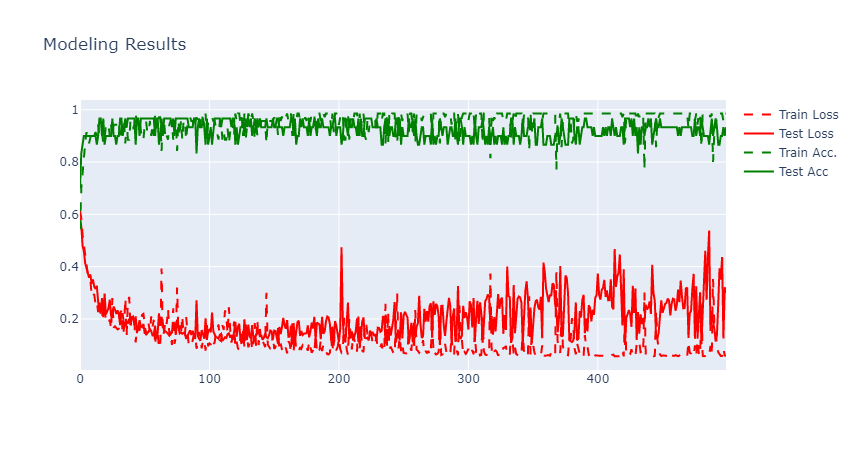

In [7]:
# visualize loss & accuracy progressions
x = list(range(epochs))
lossesAccs = np.asarray([(rl.item(), tl.item(), ra.item(), ta.item()) for (rl, tl, ra, ta)
                         in zip(trnLoss, tstLoss, trnAcc, tstAcc)])

trc = [go.Scatter({'x':x, 'y':lossesAccs[:,0], 'name':'Train Loss', 'mode':'lines',
                   'line':{'color':'red', 'dash':'dash'}}),
       go.Scatter({'x':x, 'y':lossesAccs[:,1], 'name':'Test Loss', 'mode':'lines',
                   'line':{'color':'red'}}),
       go.Scatter({'x':x, 'y':lossesAccs[:,2], 'name':'Train Acc.', 'mode':'lines',
                   'line':{'color':'green', 'dash':'dash'}}),
       go.Scatter({'x':x, 'y':lossesAccs[:,3], 'name':'Test Acc', 'mode':'lines',
                   'line':{'color':'green'}})]
plyoff.iplot(go.Figure(data=trc, layout=go.Layout(title='Modeling Results')))

In [8]:
# display targets and predictions
model.train(False)
results = pd.DataFrame({'y':np.squeeze(testData.y.detach().numpy()),
                        'yhat':np.squeeze(model(testData.x).detach().numpy())})
results['Predict'] = (results.yhat >= 0.5)*1
results['Correct'] = results.Predict == results.y
print('Testing Set Results')
display(results)

Testing Set Results


,y,yhat,Predict,Correct
0,1.0,0.999998,1,True
1,0.0,0.000939,0,True
2,1.0,0.006012,0,False
3,0.0,0.000926,0,True
4,0.0,0.001166,0,True
5,1.0,0.999306,1,True
6,1.0,0.999648,1,True
7,0.0,0.000279,0,True
8,1.0,1.000000,1,True
9,1.0,0.778061,1,True
